<a href="https://colab.research.google.com/github/Theerachod/Auto-screenshot-tool/blob/main/auto_screenshot_copy_paste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #**SET UP**

# text_height = max(thai_font.getsize(word)[1] if word not in emoji_set else emoji_font.getsize(word)[1]  for word in split_emoji) + 5

#Install libraries
!pip install python-pptx
!pip install pandas
!pip install colorama
!pip install requests
!pip install pythainlp
!pip install pilmoji
!pip install emoji

#Import necessary libraries
from google.colab import files
from IPython.display import clear_output
from colorama import Fore, Style
import ipywidgets as widgets
import os
import shutil
import requests
import io
import re
import math
import emoji
import warnings
from PIL import Image, ImageDraw, ImageFont
from pilmoji import Pilmoji
from pilmoji.source import TwemojiEmojiSource
from pythainlp import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
pd.set_option("display.max_columns", 20)

# Create function to download font
def download_file(url):
    local_filename = url.split("/")[-1]
    r = requests.get(url)
    with open(local_filename, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return

# Font url
sarabun_font_url = "https://github.com/Theerachod/automated-screenshot-project/raw/main/Fonts/Sarabun-Regular.ttf"
noto_font_url = "https://github.com/Theerachod/automated-screenshot-project/raw/main/Fonts/NotoColorEmoji-Regular.ttf"

# Download font
download_file(sarabun_font_url)
download_file(noto_font_url)

# Create function to get dummy user image
def get_image_url(url):
    r = requests.get(url)
    content = r.content
    image = Image.open(io.BytesIO(content))
    return image

# Get dummy user image
list_user_image = ["https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_0.png?raw=true",
                            "https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_1.png?raw=true",
                            "https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_2.png?raw=true",
                            "https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_3.png?raw=true",
                            "https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_4.png?raw=true",
                            "https://github.com/Theerachod/automated-screenshot-project/blob/main/User%20Icon/user_5.png?raw=true"]

for index, link in enumerate(list_user_image):
    user_image = get_image_url(link)
    user_image.save(f"user_image_{index}.png", format="PNG")

# Create function to list all existing emoji in message
def get_existing_emojis(message):
    emoji_list = []

    for char in message:
        if emoji.is_emoji(char):
            emoji_list.append(char)

    return emoji_list

# Create function to generate dynamic screenshot (text only)
def generate_dynamic_screenshot(message, width=3):
  # To hide warning message
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Set dumy message to always get the same message height
        dummy_message = "ผมเป็นมุสลิม รู้ว่ามีฮาลาล วันนี้ผมไปเหมาหมดShelfเลย สาขาใกล้บ้าน มีอยู่ 4 ชิ้นครับ"

        # Set image width and background
        img_width = int(width*100)
        background_color = (255, 255, 255, 0)
        left_margin, right_margin = 10, 10

        # Thai Sarabun font
        thai_font = ImageFont.truetype("/content/Sarabun-Regular.ttf", 16)
        # Emoji font
        emoji_font = ImageFont.truetype("/content/NotoColorEmoji-Regular.ttf", 16)

        # Get existing emoji in the message
        emoji_list = get_existing_emojis(message)
        emoji_set = list(set(emoji_list))

        # Check if there are emojis in message
        if len(emoji_set) == 0:
            split_emoji = [message]
        else:
            # Split emoji
            split_emoji = re.split(r"(" + "|".join(re.escape(e) for e in emoji_set) + r")", message)
            split_emoji = [item for item in split_emoji if item != '']

        # Tokenize message
        result = []
        for item in split_emoji:
            if item.strip() != "":
                # Tokenize non-empty non-emoji items
                tokens = word_tokenize(item)
                result.extend(tokens)
            else:
                result.append(item)

        # Calculate the message width
        each_word_width = []

        for word in result:
            if word in emoji_set:
                each_word_width.append(emoji_font.getsize(word)[0] + 2)
            else:
                each_word_width.append(thai_font.getsize(word)[0])

        # Calculate text height
        text_height = thai_font.getsize(dummy_message)[1] + 5

        # Calculate total width of message
        total_width = sum(each_word_width)

        # Calculate available space for each line
        available_space = img_width - left_margin - right_margin

        # Initialize number of line to plot message
        num_line = 1
        # Initialize the width of word to test how many line required to plot the messsage
        test_width = 0

        for word in result:
            if word in emoji_set:
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                word_width =  thai_font.getsize(word)[0]

            test_width += word_width

            if available_space > test_width:
                pass
            else:
                num_line += 1
                test_width = 0
                test_width += word_width
                if available_space > test_width:
                    pass
                else:
                    break
                    raise ValueError(f"{Fore.RED}This word '{word}' is too long to fit in 1 line")

        # Space line
        space_line = num_line + 1

        # Calculate image height
        img_height = int((num_line*text_height) + (space_line*2.5))

        # Create image
        image = Image.new("RGB", (img_width, img_height), background_color)
        # To render emoji
        pilmoji = Pilmoji(image, source=TwemojiEmojiSource)

        # Calculate space between line
        space = (img_height - text_height*num_line) / space_line

        # Initialize width counter
        width_counter = 0
        # Additional y
        added_y = (space+text_height)

        # Define x and y position
        x = left_margin
        y = space*2

        # Plot text on the image
        for word in result:
            if word in emoji_set:
                emo = True
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                emo = False
                word_width =  thai_font.getsize(word)[0]

            width_counter += word_width

            if width_counter < available_space:
                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

            else:
                # Reset x postion
                x = left_margin
                # Add space for y position
                y += added_y
                # Reset width counter
                width_counter = 0
                # Add word width
                width_counter += word_width

                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

  return image, img_height, img_width

  # Create function to generate dynamic screenshot (text with header)
def generate_dynamic_screenshot_with_header(message, header, image_path, width=3):
  # To hide warning message
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Set dumy message to always get the same message height
        dummy_message = "ผมเป็นมุสลิม รู้ว่ามีฮาลาล วันนี้ผมไปเหมาหมดShelfเลย สาขาใกล้บ้าน มีอยู่ 4 ชิ้นครับ"

        # Set image width and background
        img_width = int(width*100)
        background_color = (255, 255, 255, 0)
        left_margin, right_margin = 10, 10

        # Open the anonymous user image
        image_to_paste = Image.open(image_path)

        # Resize the image to fit the desired size
        desired_width, desired_height = 30, 30
        image_to_paste = image_to_paste.resize((desired_width, desired_height))

        # Thai Sarabun font
        thai_font = ImageFont.truetype("/content/Sarabun-Regular.ttf", 16)
        # Emoji font
        emoji_font = ImageFont.truetype("/content/NotoColorEmoji-Regular.ttf", 16)

        # Get existing emoji in the message
        emoji_list = get_existing_emojis(message)
        emoji_set = list(set(emoji_list))

        # Check if there are emojis in message
        if len(emoji_set) == 0:
            split_emoji = [message]
        else:
            # Split emoji
            split_emoji = re.split(r"(" + "|".join(re.escape(e) for e in emoji_set) + r")", message)
            split_emoji = [item for item in split_emoji if item != '']

        # Tokenize message
        result = []
        for item in split_emoji:
            if item.strip() != "":
                # Tokenize non-empty non-emoji items
                tokens = word_tokenize(item)
                result.extend(tokens)
            else:
                result.append(item)

        # Calculate the message width
        each_word_width = []

        for word in result:
            if word in emoji_set:
                each_word_width.append(emoji_font.getsize(word)[0] + 2)
            else:
                each_word_width.append(thai_font.getsize(word)[0])

        # Calculate text height
        text_height = thai_font.getsize(dummy_message)[1] + 5

        # Calculate total width of message
        total_width = sum(each_word_width)

        # Calculate available space for each line
        available_space = img_width - left_margin - right_margin

        # Initialize number of line to plot message
        num_line = 2
        # Initialize the width of word to test how many line required to plot the messsage
        test_width = 0

        for word in result:
            if word in emoji_set:
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                word_width =  thai_font.getsize(word)[0]

            test_width += word_width

            if available_space > test_width:
                pass
            else:
                num_line += 1
                test_width = 0
                test_width += word_width
                if available_space > test_width:
                    pass
                else:
                    break
                    raise ValueError(f"{Fore.RED}This word '{word}' is too long to fit in 1 line")

        # Space line
        space_line = num_line + 1

        # Calculate image height
        img_height = int((num_line*text_height) + (space_line*2.5))

        # Create image
        image = Image.new("RGB", (img_width, img_height), background_color)
        # To render emoji
        pilmoji = Pilmoji(image, source=TwemojiEmojiSource)

        # Calculate space between line
        space = (img_height - text_height*num_line) / space_line

        # Initialize width counter
        width_counter = 0
        # Additional y
        added_y = (space+text_height)

        # Define x and y position
        x = left_margin
        y = space*2

        # Plot header of screenshot
        pilmoji.text((int(50), int(y)), header, font=thai_font, fill="black")
        # Add space for y position
        y += added_y

        # Define the position where you want to paste the image
        x_position = 10
        y_position = 2
        paste_position = (x_position, y_position)

        # Paste the resized image onto the chart at the specified position
        image.paste(image_to_paste, paste_position, image_to_paste)

        # Plot text on the image
        for word in result:
            if word in emoji_set:
                emo = True
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                emo = False
                word_width =  thai_font.getsize(word)[0]

            width_counter += word_width

            if width_counter < available_space:
                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

            else:
                # Reset x postion
                x = left_margin
                # Add space for y position
                y += added_y
                # Reset width counter
                width_counter = 0
                # Add word width
                width_counter += word_width

                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

  return image, img_height, img_width

# Create function to generate dynamic screenshot (text with reaction)
def generate_dynamic_screenshot_with_reaction(message, reaction, width=3):
  # To hide warning message
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Set dumy message to always get the same message height
        dummy_message = "ผมเป็นมุสลิม รู้ว่ามีฮาลาล วันนี้ผมไปเหมาหมดShelfเลย สาขาใกล้บ้าน มีอยู่ 4 ชิ้นครับ"

        # Set image width and background
        img_width = int(width*100)
        background_color = (255, 255, 255, 0)
        left_margin, right_margin = 10, 10

        # Thai Sarabun font
        thai_font = ImageFont.truetype("/content/Sarabun-Regular.ttf", 16)
        # Emoji font
        emoji_font = ImageFont.truetype("/content/NotoColorEmoji-Regular.ttf", 16)

        # Get existing emoji in the message
        emoji_list = get_existing_emojis(message)
        emoji_set = list(set(emoji_list))

        # Check if there are emojis in message
        if len(emoji_set) == 0:
            split_emoji = [message]
        else:
            # Split emoji
            split_emoji = re.split(r"(" + "|".join(re.escape(e) for e in emoji_set) + r")", message)
            split_emoji = [item for item in split_emoji if item != '']

        # Tokenize message
        result = []
        for item in split_emoji:
            if item.strip() != "":
                # Tokenize non-empty non-emoji items
                tokens = word_tokenize(item)
                result.extend(tokens)
            else:
                result.append(item)

        # Calculate the message width
        each_word_width = []

        for word in result:
            if word in emoji_set:
                each_word_width.append(emoji_font.getsize(word)[0] + 2)
            else:
                each_word_width.append(thai_font.getsize(word)[0])

        # Calculate text height
        text_height = thai_font.getsize(dummy_message)[1] + 5

        # Calculate total width of message
        total_width = sum(each_word_width)

        # Calculate available space for each line
        available_space = img_width - left_margin - right_margin

        # Initialize number of line to plot message
        num_line = 2
        # Initialize the width of word to test how many line required to plot the messsage
        test_width = 0

        for word in result:
            if word in emoji_set:
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                word_width =  thai_font.getsize(word)[0]

            test_width += word_width

            if available_space > test_width:
                pass
            else:
                num_line += 1
                test_width = 0
                test_width += word_width
                if available_space > test_width:
                    pass
                else:
                    break
                    raise ValueError(f"{Fore.RED}This word '{word}' is too long to fit in 1 line")

        # Space line
        space_line = num_line + 1

        # Calculate image height
        img_height = int((num_line*text_height) + (space_line*2.5))

        # Create image
        image = Image.new("RGB", (img_width, img_height), background_color)
        # To render emoji
        pilmoji = Pilmoji(image, source=TwemojiEmojiSource)

        # Calculate space between line
        space = (img_height - text_height*num_line) / space_line

        # Initialize width counter
        width_counter = 0
        # Additional y
        added_y = (space+text_height)

        # Define x and y position
        x = left_margin
        y = space*2

        # Plot no. of reaction
        pilmoji.text((int(x), int(y)), f"Reaction: {reaction}", font=thai_font, fill="black")
        # Reset x postion
        x = left_margin
        # Add space for y position
        y += added_y

        # Plot text on the image
        for word in result:
            if word in emoji_set:
                emo = True
                word_width = emoji_font.getsize(word)[0] + 2
            else:
                emo = False
                word_width =  thai_font.getsize(word)[0]

            width_counter += word_width

            if width_counter < available_space:
                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

            else:
                # Reset x postion
                x = left_margin
                # Add space for y position
                y += added_y
                # Reset width counter
                width_counter = 0
                # Add word width
                width_counter += word_width

                if emo:
                    try:
                        pilmoji.text((int(x + 2), int(y + 3)), word, font=emoji_font, fill="black")
                        x += word_width
                    except:
                        pass

                else:
                    try:
                        pilmoji.text((int(x), int(y)), word, font=thai_font, fill="black")
                        x += word_width
                    except:
                        pass

  return image, img_height, img_width

# Create function to transform user inputs to dataframe
def transform_input_to_df(message_boxes, link_boxes, reaction_boxes, header_boxes):
    global df
    # Create list to contain value
    messages = []
    links = []
    reactions = []
    headers = []

    for message_box, link_box in zip(message_boxes, link_boxes):
                messages.append(message_box.value)
                links.append(link_box.value)

    if reaction_boxes == None:
            for i in range(num_message):
                reactions.append(None)
    else:
        for reaction_box in reaction_boxes:
            reactions.append(reaction_box.value)

    if header_boxes == None:
            for i in range(num_message):
                headers.append(None)
    else:
        for header_box in header_boxes:
            headers.append(header_box.value)

    # Create a DataFrame from the user inputs
    data = {"Message": messages, "Link": links, "Reaction":reactions, "Header":headers}
    df = pd.DataFrame(data)

    return df

# Define function to create PowerPoint with screenshots
def create_PowerPoint(data, type_screenshot, highlight_edge=None):
    # Initiate page counter
    page_counter = 0
    # PowerPoint slide height
    pp_height = Inches(7.5)
    #PowerPoint slide width
    pp_width = Inches(10)

    # Create PowerPoint slide
    presentation = Presentation()
    slide = presentation.slides.add_slide(presentation.slide_layouts[page_counter])

    # Delete title and subtitle of title page
    for shape in slide.shapes:
        if shape.has_text_frame:
            if shape.placeholder_format.idx == 1:  #Subtitle placeholder
                slide.shapes._spTree.remove(shape._element)

    # Delete all text boxes of slide
    for shape in slide.shapes:
                if shape.has_text_frame:
                    sp = shape._element
                    sp.getparent().remove(sp)

    # Define the coordinates and size of the image
    left = Inches(0.2)
    top = Inches(0.2)

    for index, row in data.iterrows():
        message = row["Message"]
        url = row["Link"]
        reaction = row["Reaction"]
        header = row["Header"]

        if type_screenshot == "only text":
            # Create image and draw message
            image, img_height, img_width = generate_dynamic_screenshot(message, width=3)
            image.save(f"message_number_{index}.png", dpi=(300, 300))

        elif type_screenshot == "text with header":
            # Create image and draw message
            image, img_height, img_width = generate_dynamic_screenshot_with_header(message, header, image_path, width=3)
            image.save(f"message_number_{index}.png", dpi=(300, 300))

        elif type_screenshot == "text with reaction":
            # Create image and draw message
            image, img_height, img_width = generate_dynamic_screenshot_with_reaction(message, reaction, width=3)
            image.save(f"message_number_{index}.png", dpi=(300, 300))

        display(image)
        print("\n")

        # Define the size of the image
        height = Inches(img_height/100)
        width = Inches(img_width/100)

        if (left + width) < pp_width:
            if (top) < pp_height:
                slide.shapes.add_picture(f"message_number_{index}.png", left, top, width, height) # Add the image to the slide
                image_shape = slide.shapes[-1] # Get the image shape object
                hyperlink_address = url # URL link
                image_shape.click_action.hyperlink.address = hyperlink_address # Add hyperlink to image
                outline = image_shape.line
                outline.width = Pt(3/4)
                if highlight_edge:
                    try:
                        outline.color.rgb = RGBColor.from_string(highlight_edge)
                    except:
                        pass
                else:
                    pass
                top += (height+Inches(0.2)) # Adjust the vertical position for the next text box

            else:
                top = Inches(0.2) # Reset top position
                left += (width+Inches(0.2))  # Adjust the left position
                if (left + width) < pp_width:
                    slide.shapes.add_picture(f"message_number_{index}.png", left, top, width, height) # Add the image to the slide
                    image_shape = slide.shapes[-1] # Get the image shape object
                    hyperlink_address = url # URL link
                    image_shape.click_action.hyperlink.address = hyperlink_address # Add hyperlink to image
                    outline = image_shape.line
                    outline.width = Pt(3/4)
                    if highlight_edge:
                        try:
                            outline.color.rgb = RGBColor.from_string(highlight_edge)
                        except:
                            pass
                    else:
                        pass
                    top += (height+Inches(0.2)) # Adjust the vertical position for the next text box
                else:
                    # Create a new slide
                    page_counter+= 1
                    slide = presentation.slides.add_slide(presentation.slide_layouts[page_counter])
                    # Delete title and subtitle boxes
                    for shape in slide.shapes:
                        if shape.has_text_frame:
                            sp = shape._element
                            sp.getparent().remove(sp)
                    left = Inches(0.2)  # Reset the left position
                    top = Inches(0.2)   # Reset the top position
                    slide.shapes.add_picture(f"message_number_{index}.png", left, top, width, height) # Add the image to the new slide
                    image_shape = slide.shapes[-1] # Get the image shape object
                    hyperlink_address = url # URL link
                    image_shape.click_action.hyperlink.address = hyperlink_address # Add hyperlink to image
                    outline = image_shape.line
                    outline.width = Pt(3/4)
                    if highlight_edge:
                        try:
                            outline.color.rgb = RGBColor.from_string(highlight_edge)
                        except:
                            pass
                    else:
                        pass
                    top += (height+Inches(0.2)) # Adjust the vertical position for the next text box

        else:
            # Create a new slide
            page_counter+= 1
            slide = presentation.slides.add_slide(presentation.slide_layouts[page_counter])
            # Delete title and subtitle boxes
            for shape in slide.shapes:
                if shape.has_text_frame:
                    sp = shape._element
                    sp.getparent().remove(sp)
            left = Inches(0.2)  # Reset the left position
            top = Inches(0.2)   # Reset the top position
            slide.shapes.add_picture(f"message_number_{index}.png", left, top, width, height) # Add the image to the new slide
            image_shape = slide.shapes[-1] # Get the image shape object
            hyperlink_address = url # URL link
            image_shape.click_action.hyperlink.address = hyperlink_address # Add hyperlink to image
            outline = image_shape.line
            outline.width = Pt(3/4)
            if highlight_edge:
                try:
                    outline.color.rgb = RGBColor.from_string(highlight_edge)
                except:
                    pass
            else:
                pass
            top += (height+Inches(0.2)) # Adjust the vertical position for the next text box

    presentation.save("result_screenshot.pptx")

#Print result
clear_output()
print(Fore.GREEN + "[Success] All necessary dependencies has been installed")

[Success] All necessary dependencies has been installed


#**Step 1: Select screenshot version and enter number of message to generate**

In [ ]:
#@markdown ##### **Select version of screenshot and press "Run"**
type_screenshot = "text with header" # @param ["only text", "text with header", "text with reaction"]

if type_screenshot == "text with header":

    print(f"Screenshot type: {type_screenshot}")
    print("\n")
    # List all image paths
    image_paths = ["/content/user_image_0.png", "/content/user_image_1.png", "/content/user_image_2.png", "/content/user_image_3.png", "/content/user_image_4.png", "/content/user_image_5.png"]
    # Create dropdown list to select image
    image_dropdown = widgets.Dropdown(options=image_paths, description='Select image')

    # Set padding or margin to the displayed image
    image_dropdown.layout.width = '250px' # Adjust width as needed

    # Define a Function to Display the Image
    def display_image(image_path):
        plt.figure(figsize=(2, 2))  # adjust the size of the displayed image box
        img = plt.imread(image_path)
        image_name = re.findall(r"user_image_\d+", image_dropdown.value)[0]
        image_name = image_name.replace("_"," ")
        plt.imshow(img)
        plt.axis('off')
        print("\n")
        plt.show()
        print("\n")
        print(f"Selected image: {image_name}")


    # Interact with the Dropdown Widget
    widgets.interact(display_image, image_path=image_dropdown);

else:
    print(f"Screenshot type: {type_screenshot}")


Screenshot type: text with header




interactive(children=(Dropdown(description='Select image', layout=Layout(width='250px'), options=('/content/us…

In [ ]:
#@markdown ##### **Enter number of messages to generate and press "Run" then enter the messages/ URL/ Header or Reaction**

# Define number of box to put messages and links
num_message = 3 #@param {type:"number"}

if num_message < 0:
    raise ValueError(Fore.RED+"Input must be equal or more than 0")
elif num_message > 50:
    print("Maximum message is 50")
    print("\n")
    num_message = 50
else:
    pass

if type_screenshot == "only text":

    # Create list to store message and link
    message_boxes = list()
    link_boxes = list()
    reaction_boxes = None
    header_boxes = None

    for num in range(num_message):
        # Box to input message
        message = widgets.Text(value="", description=f"Message {num+1}:", placeholder=f"Enter message")
        message.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        message_boxes.append(message)

        # Box to input link
        link = widgets.Text(value="", description=f"Link {num+1}:", placeholder=f"Enter link")
        link.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        link_boxes.append(link)

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []

    for num in range(num_message):
        column_box = widgets.HBox([message_boxes[num], link_boxes[num]])
        column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
        column_boxes.append(column_box)

elif type_screenshot == "text with header":

    # Create list to store message, link, and reaction
    message_boxes = list()
    link_boxes = list()
    reaction_boxes = None
    header_boxes = list()

    for num in range(num_message):
        # Box to input message
        message = widgets.Text(value="", description=f"Message {num+1}:", placeholder=f"Enter message")
        message.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        message_boxes.append(message)

        # Box to input link
        link = widgets.Text(value="", description=f"Link {num+1}:", placeholder=f"Enter link")
        link.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        link_boxes.append(link)

    # Box to input link
        header = widgets.Text(value="", description=f"Header {num+1}:", placeholder=f"Enter message header")
        header.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        header_boxes.append(header)

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []

    for num in range(num_message):
        column_box = widgets.HBox([message_boxes[num], link_boxes[num], header_boxes[num]])
        column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
        column_boxes.append(column_box)

elif type_screenshot == "text with reaction":

    # Create list to store message, link, and reaction
    message_boxes = list()
    link_boxes = list()
    reaction_boxes = list()
    header_boxes = None

    for num in range(num_message):
        # Box to input message
        message = widgets.Text(value="", description=f"Message {num+1}:", placeholder=f"Enter message")
        message.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        message_boxes.append(message)

        # Box to input link
        link = widgets.Text(value="", description=f"Link {num+1}:", placeholder=f"Enter link")
        link.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        link_boxes.append(link)

    # Box to input link
        reaction = widgets.Text(value="", description=f"Reaction {num+1}:", placeholder=f"Enter reaction")
        reaction.layout.margin = "0 50px 0 0"  # Add right margin for spacing
        reaction_boxes.append(reaction)

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []

    for num in range(num_message):
        column_box = widgets.HBox([message_boxes[num], link_boxes[num], reaction_boxes[num]])
        column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
        column_boxes.append(column_box)

# Display the dropdown lists and filter button
display(*column_boxes)

#**Step 2: Create screenshots and download result file**

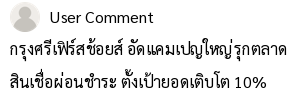

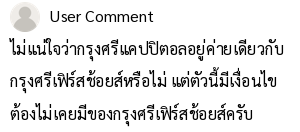

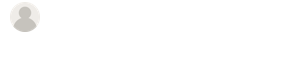

In [ ]:
#@markdown ##### **Enter hex color to color edge of screenshot and press "Run"**

hex_color = "" # @param {type:"string"}
# Check if user set hex_color or not
if hex_color == "":
    color_code = None
else:
    color_code = hex_color.replace("#","")

if type_screenshot == "text with header":
    image_path = image_dropdown.value
else:
    pass

# Transform user input to dataframe
data = transform_input_to_df(message_boxes, link_boxes, reaction_boxes, header_boxes)
# Create PowerPoint slide with screenshot
#create_PowerPoint(data, type_screenshot, highlight_edge = color_code)
create_PowerPoint(data, type_screenshot, highlight_edge=color_code)

In [ ]:
#@markdown ##### **Download PowerPoint result file**

# Download file to local computer
files.download("result_screenshot.pptx")

# Print result
print(Fore.GREEN + "[Success]", "😎 Yay!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Success] 😎 Yay!


#**Extension: Create screenshot with customized width**

In [ ]:
#@markdown ##### **Select version of screenshot and press "Run"**
extension_type_screenshot = "text with header" # @param ["only text", "text with header", "text with reaction"]

if extension_type_screenshot == "text with header":

    print(f"Screenshot type: {extension_type_screenshot}")
    print("\n")
    # List all image paths
    image_paths = ["/content/user_image_0.png", "/content/user_image_1.png", "/content/user_image_2.png", "/content/user_image_3.png", "/content/user_image_4.png", "/content/user_image_5.png"]
    # Create dropdown list to select image
    image_dropdown = widgets.Dropdown(options=image_paths, description='Select image')

    # Set padding or margin to the displayed image
    image_dropdown.layout.width = '250px' # Adjust width as needed

    # Define a Function to Display the Image
    def display_image(image_path):
        plt.figure(figsize=(2, 2))  # adjust the size of the displayed image box
        img = plt.imread(image_path)
        image_name = re.findall(r"user_image_\d+", image_dropdown.value)[0]
        image_name = image_name.replace("_"," ")
        plt.imshow(img)
        plt.axis('off')
        print("\n")
        plt.show()
        print("\n")
        print(f"Selected image: {image_name}")


    # Interact with the Dropdown Widget
    widgets.interact(display_image, image_path=image_dropdown);

else:
    print(f"Screenshot type: {extension_type_screenshot}")

Screenshot type: text with header




interactive(children=(Dropdown(description='Select image', layout=Layout(width='250px'), options=('/content/us…

In [ ]:
#@markdown ##### **Define the message of the screenshot**
if extension_type_screenshot == "only text":
    message = widgets.Text(value="", description="Message:", placeholder=f"Enter message")
    message.layout.margin = "0 50px 0 0"  # Add right margin for spacing

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []
    column_box = widgets.HBox([message])
    column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
    column_boxes.append(column_box)

elif extension_type_screenshot == "text with header":

    # Box to input message
    message = widgets.Text(value="", description="Message:", placeholder=f"Enter message")
    message.layout.margin = "0 50px 0 0"  # Add right margin for spacing

    # Box to input header
    header = widgets.Text(value="", description=f"Header:", placeholder=f"Enter message header")
    header.layout.margin = "0 50px 0 0"  # Add right margin for spacing

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []
    column_box = widgets.HBox([message, header])
    column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
    column_boxes.append(column_box)

elif extension_type_screenshot == "text with reaction":
    # Box to input message
    message = widgets.Text(value="", description="Message:", placeholder=f"Enter message")
    message.layout.margin = "0 50px 0 0"  # Add right margin for spacing

    # Box to input reaction
    reaction = widgets.Text(value="", description="Reaction:", placeholder=f"Enter reaction")
    reaction.layout.margin = "0 50px 0 0"  # Add right margin for spacing

    # Create VBox widgets to stack the dropdown lists vertically
    column_boxes = []
    column_box = widgets.HBox([message, reaction])
    column_box.layout.margin = "0 0 5px 0"  # Add bottom margin for spacing
    column_boxes.append(column_box)

display(*column_boxes)

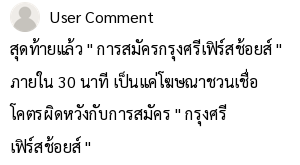

In [ ]:
#@markdown ##### **Define the width of the screenshot"**
width = 3 # @param {type:"number"}

if extension_type_screenshot == "only text":
    # Create image and draw message
    image, img_height, img_width = generate_dynamic_screenshot(message.value, width)
    display(image)
    image.save(f"message_number_{index}.png", dpi=(300, 300))

elif extension_type_screenshot == "text with header":
    # Get image path
    image_path = image_dropdown.value
    # Create image and draw message
    image, img_height, img_width = generate_dynamic_screenshot_with_header(message.value, header.value, image_path, width)
    display(image)
    image.save(f"message_number_{index}.png", dpi=(300, 300))

elif extension_type_screenshot == "text with reaction":
    # Create image and draw message
    image, img_height, img_width = generate_dynamic_screenshot_with_reaction(message.value, reaction.value, width)
    display(image)
    image.save(f"message_number_{index}.png", dpi=(300, 300))